
# Projeto: Fome Zero

Coleta dos dados: [Zomato Restaurants](https://www.kaggle.com/datasets/akashram/zomato-restaurants-autoupdated-dataset?resource=download&select=zomato.csv)

### 0.Imports

In [17]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import streamlit as st
import inflection
import folium
from folium.plugins import MarkerCluster
from PIL import Image
from streamlit_folium import folium_static

# Converte um número cientifico para número decimal
pd.set_option('display.float_format', lambda x: '%.f' % x)


### 1. Funções


In [2]:
def country_name(name):
    """Está função tem a responsabilidade de converter o número inteiro, correspondente a um país em uma string com o nome do país
        
        Tipo de conversão
        1. Número inteiro -> String com nome do país
        
        return: nome do país
    """
    
    country_name = {
        1: "India",
        14: "Australia",
        30: "Brazil",
        37: "Canada",
        94: "Indonesia",
        148: "New Zeland",
        162: "Philippines",
        166: "Qatar",
        184: "Singapure",
        189: "South Africa",
        191: "Sri Lanka",
        208: "Turkey",
        214: "United Arab Emirates",
        215: "England",
        216: "United States of America",
    }
    
    return country_name[name]

def price_type(price_range):
    """Está função tem a responsabilidade de converter um número inteiro a um correspondente nível de precificação
        
        Tipo de conversão
        1. Número inteiro: 1, 2, 3 e 4
        2. String derivada dos números: 
            1 = cheap
            2 = normal
            3 = expensive
            4 = gourmet
        
        return: string com o nível de precificação
    """
    
    if price_range == 1:
        return "cheap"
    elif price_range == 2:
        return "normal"
    elif price_range == 3:
        return "expensive"
    else:
        return "gourmet"

def color_name(color_code):
    '''Função que cria cores baseada em códigos hexadecimais
    
    return: cor referente a um código hexadecimal
    '''   
    
    COLORS = {
        "3F7E00": "darkgreen",
        "5BA829": "green",
        "9ACD32": "lightgreen",
        "CDD614": "orange",
        "FFBA00": "red",
        "CBCBC8": "darkred",
        "FF7800": "darkred",
    }
    
    return COLORS[color_code]

def clean_dataframe(df):
    ''' Função que tem a responsabilidade de limpar o dataframe
    
        Tipos de limpeza:
        1. Remoação de valores outliers
        2. Remoção de valores nulos
        3. Remocação de valores duplicados
        4. Categorizar os valores da coluna cuisines com apenas um tipo de culinária
        
        return: um dataframe limpo baseado nos tipos descritos acima    
    
    '''
    # Excluindo outlier do dataset
    df = df.loc[df['Restaurant ID'] != 16608070, :]
    
    df = df.loc[df['Average Cost for two'] != 0, :]
    
    # Removendo valores nulos do dataset
    df = df.loc[df['Cuisines'].notnull(), :]

    # Excluindo dados duplicados do datatset
    df = df.loc[:, :].drop_duplicates().reset_index(drop=True)

    # Categorizando os restaurantes por um tipo de culinária
    df['Cuisines'] = df.loc[:, 'Cuisines'].apply(lambda x: x.split(",")[0])
    
    return df
    

def rename_columns(dataframe):
    '''Função que formata o nome das colunas    
    
        1. Recebe um dataframe
        2. Localiza os títulos
        3. Coloca os títulos em letras minúsculas
        4. Remove os espaços
        5. Insere um _ no lugar dos espaços
        6 Transforma os títulos em uma lista
        
        return: um dataframe com o cabeçalho formatado "texto_texto"
    '''
    
    df = dataframe.copy()
    title = lambda x: inflection.titleize(x)
    snakecase = lambda x: inflection.underscore(x)
    spaces = lambda x: x.replace(" ", "")
    cols_old = list(df.columns)
    cols_old = list(map(title, cols_old))
    cols_old = list(map(spaces, cols_old))
    cols_new = list(map(snakecase, cols_old))
    df.columns = cols_new
    
    return df

### 2. Carregando os dados

In [3]:
df_raw = pd.read_csv('dataset/zomato.csv')

### 3. Limpando o dados

In [4]:
# Formatando o nome das colunas e limpando o dataset
df = rename_columns(clean_dataframe(df_raw))

### 4. Criando colunas

In [5]:
# Criando a coluna price_type de acordo com a coluna price_range
df['price_type'] = df['price_range'].apply(lambda x: price_type(x))

# Criando a coluna color name de acordo com a coluna rating_color
df['color_name'] = df['rating_color'].apply(lambda x: color_name(x))

# Criando a coluna country_name baseada na coluna country_code
df['country_name'] = df['country_code'].apply(lambda x: country_name(x))

# Criando a coluna price_in_dollar baseada nas colunas currency e average_cost_for_two
df['price_in_dollar'] = df[['currency', 'average_cost_for_two']].apply( lambda x: ( x['average_cost_for_two'] / 12.85  ) if x['currency'] == 'Botswana Pula(P)'  else
                                                                                      ( x['average_cost_for_two'] / 5.31  ) if x['currency'] == 'Brazilian Real(R$)' else
                                                                                      ( x['average_cost_for_two'] / 1  ) if x['currency'] == 'Dollar($)' else
                                                                                      ( x['average_cost_for_two'] / 3.67  ) if x['currency'] == 'Emirati Diram(AED)' else
                                                                                      ( x['average_cost_for_two'] / 82.68  ) if x['currency'] == 'Indian Rupees(Rs.)' else
                                                                                      ( x['average_cost_for_two'] / 15608.45  ) if x['currency'] == 'Indonesian Rupiah(IDR)' else
                                                                                      ( x['average_cost_for_two'] / 1.57  ) if x['currency'] == 'NewZealand($)' else
                                                                                      ( x['average_cost_for_two'] / 0.819257  ) if x['currency'] == 'Pounds(£)' else
                                                                                      ( x['average_cost_for_two'] / 3.64  ) if x['currency'] == 'Qatari Rial(QR)' else
                                                                                      ( x['average_cost_for_two'] / 17.59  ) if x['currency'] == 'Rand(R)' else
                                                                                      ( x['average_cost_for_two'] / 366.86  ) if x['currency'] == 'Sri Lankan Rupee(LKR)' else
                                                                                      ( x['average_cost_for_two'] / 18.65  ) if x['currency'] == 'Turkish Lira(TL)' else 0, axis=1 )

## 3. Visão Geral

In [19]:
df_save = df.to_csv('data.csv', index=False, enconding='UTF-8')

In [15]:
df.loc[:, 'country_name'].sort_values().unique()

array(['Australia', 'Brazil', 'Canada', 'England', 'India', 'Indonesia',
       'New Zeland', 'Philippines', 'Qatar', 'Singapure', 'South Africa',
       'Sri Lanka', 'Turkey', 'United Arab Emirates',
       'United States of America'], dtype=object)

### 1. Quantos restaurantes únicos estão registrados?

In [21]:
# Selecionar a coluna com o id restaurantes e calcular a quantidade
restaurant_unique = df.loc[:, 'restaurant_id'].count()
print(f'A quantidade de restaurantes únicos na base dados é: {restaurant_unique}')

A quantidade de restaurantes únicos na base dados é: 6878


### 2. Quantos países únicos estão registrados?

In [22]:
# Selecionar a coluna com o código do país e calcular a quantidade 
country_unique = df.loc[:, 'country_code'].nunique()
print(f'A quantidade de países únicos registrados na base de dados é: {country_unique}')

A quantidade de países únicos registrados na base de dados é: 15


### 3. Quantas cidades únicas estão registradas?

In [23]:
# Selecionar a coluna com as cidades e calcular a quantidade
city_unique = df.loc[:, 'city'].nunique()
print(f'A quantidade de cidades únicas registradas na base de dados é: {city_unique}')

A quantidade de cidades únicas registradas na base de dados é: 125


### 4. Qual o total de avaliações feitas?

In [24]:
# Selecionar a coluna com as avaliações e somar o total de avaliações
votes_total = df.loc[:, 'votes'].sum()
print(f'O total de avaliações registradas na base de dados é: {votes_total}')

O total de avaliações registradas na base de dados é: 4188309


### 5. Qual o total de tipos de culinária registrados?

In [25]:
# Selecionar a coluna de culinária e contar a quantidade total
cuisine_total = df.loc[:, 'cuisines'].nunique()
print(f'O total de tipos culinários registrados na base de dados é: {cuisine_total}')

O total de tipos culinários registrados na base de dados é: 164


## 4. Visão País

### 1. Qual o nome do país que possui mais cidades registradas?

In [38]:
# Selecionar as colunas pais e cidade e agrupar por cidade
df_country = df.loc[:, ['country_name', 'city']].groupby('country_name').nunique().reset_index().sort_values(by='city', ascending=False)
df_country

,country_name,city
4,India,49
14,United States of America,22
7,Philippines,12
10,South Africa,12
3,England,5
6,New Zeland,4
13,United Arab Emirates,4
0,Australia,3
1,Brazil,3
2,Canada,3


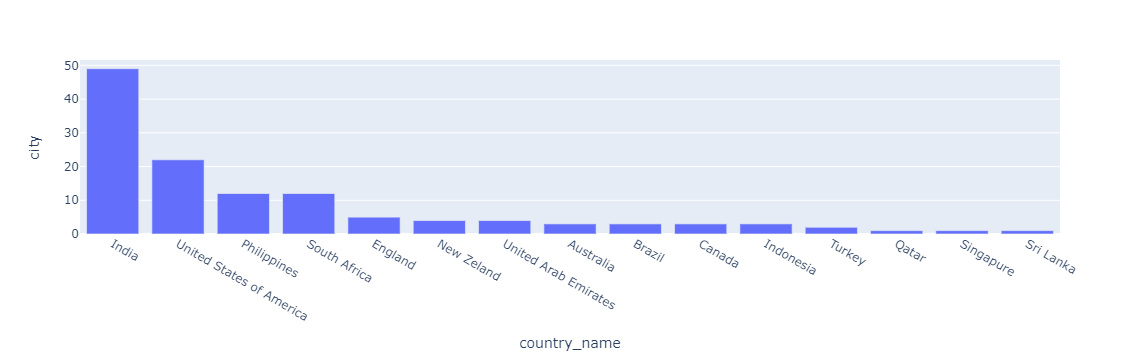

In [47]:
fig = px.bar(df_country, x='country_name', y='city')
fig.show()

### 2. Qual o nome do país que possui mais restaurantes registrados?

In [56]:
# Selecionar as colunas com id do restaurante e o nome do país e contar a quantidade de países de acordo com o id do restaurante
restaurant_country = ( df[['restaurant_id', 'country_name']].groupby('country_name')
                      .nunique()
                      .sort_values(by='restaurant_id', ascending=False)
                      .reset_index() )

restaurant_country

,country_name,restaurant_id
0,India,3111
1,United States of America,1374
2,England,400
3,South Africa,346
4,United Arab Emirates,300
5,Brazil,240
6,New Zeland,239
7,Canada,180
8,Australia,179
9,Turkey,159


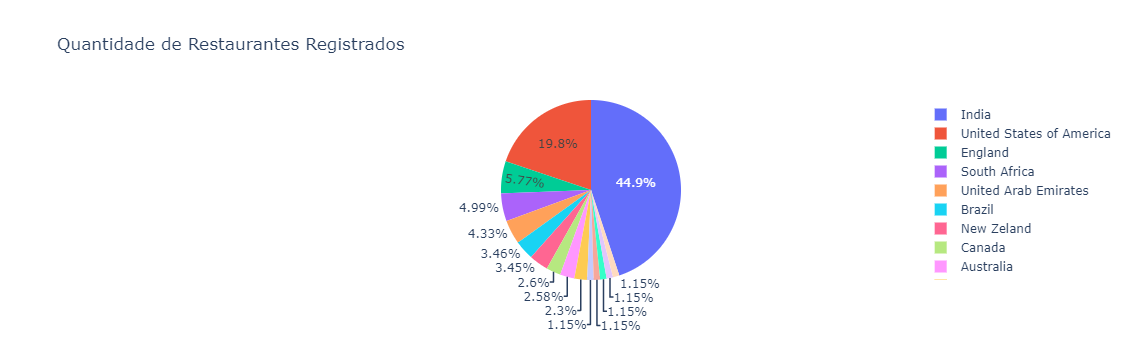

In [58]:
fig = px.pie(restaurant_country, values='restaurant_id', names='country_name', title='Quantidade de Restaurantes Registrados')
fig.show()

### 3. Qual o nome do país que possui mais restaurantes com o nível de preço igual a 4 registrados?

In [70]:
# Selecionar as colunas com país, restaurantes e nível de preço, fazer um filtro no nível de preço que seja igual a 4
cols = ['country_name', 'price_range']
restaurant_level_4 = ( df.loc[df['price_range'] == 4, cols].groupby('country_name')
                                                            .count()
                                                            .sort_values(by='price_range', ascending=False)
                                                            .reset_index() )
restaurant_level_4

,country_name,price_range
0,United States of America,415
1,South Africa,221
2,India,195
3,Brazil,148
4,United Arab Emirates,102
5,England,79
6,New Zeland,79
7,Turkey,59
8,Singapure,58
9,Canada,54


### 4. Qual o nome do país que possui a maior quantidade de tipos de culinária distintos?

In [71]:
# Selecionar a coluna com os países, agrupar pelos tipos de culinária, aplicar a função nunique()
cols = ['country_name', 'cuisines']
country_cuisines = ( df.loc[:, cols].groupby('country_name')
                    .nunique()
                    .sort_values(by='cuisines', ascending=False)
                    .reset_index() )
country_cuisines

,country_name,cuisines
0,India,77
1,United States of America,74
2,England,52
3,United Arab Emirates,46
4,Australia,43
5,Brazil,43
6,Canada,42
7,South Africa,42
8,New Zeland,37
9,Qatar,31


### 5. Qual o nome do país que possui a maior quantidade de avaliações feitas?

In [ ]:
# Selecionar a coluna país e avaliações, agrupar pelo nome do país
#e aplicar a função count() para contar a quantidade de avaliações na base de dados

cols = ['country_name', 'votes']
country_votes = (df.loc[:, cols].groupby('country_name').count()
                 .sort_values(by='votes', ascending=False)
                 .reset_index() )
country_votes

### 6. Qual o nome do país que possui a maior quantidade de restaurantes que fazem entrega?

In [ ]:
# Selecionar as colunas com o nome dos países e se fazem delivery,
# agrupar pelo nome dos países, aplicar a função max() e ordenar pela quantidade de entregas 

cols = ['country_name', 'is_delivering_now']
country_delivery = ( df.loc[:, cols].groupby('country_name')
                    .count()
                    .sort_values(by='is_delivering_now', ascending=False)
                    .reset_index())
country_delivery.columns = ['Country', 'Number of Deliveries']
country_delivery

### 7. Qual o nome do país que possui a maior quantidade de restaurantes que aceitam reservas?

In [ ]:
# Selecionar as colunas do país, id do restaurant e reservas de mesas e contar a quantidade de restaurantes que aceitam reserva
booking_filter = df['has_table_booking'] == 1
cols = ['country_name', 'has_table_booking']
country_booking = ( df.loc[booking_filter, cols].groupby('country_name')
                   .count()
                   .sort_values(by='has_table_booking', ascending=False) 
                  .reset_index() )
country_booking.columns = ['Country', 'Table Booking']
country_booking

### 8. Qual o nome do país que possui, na média, a maior quantidade de avaliações registrada?

In [15]:
# Selecionar as colunas do país e o agregado de votos, agrupar pelo país e calcular a média

cols = ['country_name', 'votes']
country_rating = df.loc[:, cols].groupby('country_name').mean().sort_values(by='votes', ascending=False).reset_index()
country_rating

,country_name,votes
0,Indonesia,1113
1,India,902
2,Australia,731
3,Turkey,630
4,Philippines,605
5,United Arab Emirates,604
6,Canada,585
7,United States of America,381
8,Qatar,376
9,South Africa,239


### 9. Qual o nome do país que possui, na média, a maior nota média registrada?

In [10]:
# Selecionar a coluna país e votos agregados aplicando a função max() para recuperar o maior valor
cols = ['restaurant_id', 'country_name', 'aggregate_rating']
rating_max = df.loc[:, cols].groupby('country_name').max().sort_values(by='restaurant_id').reset_index()
rating_max

,country_name,restaurant_id,aggregate_rating
0,United States of America,18083405,5
1,Canada,18139426,5
2,Sri Lanka,18279085,5
3,Brazil,18334183,5
4,Australia,18441945,5
5,Singapure,18496115,5
6,Turkey,18514851,5
7,South Africa,18633161,5
8,Qatar,18729443,5
9,New Zeland,18749437,5


### 10. Qual o nome do país que possui, na média, a menor nota média registrada?

In [ ]:
# Selecionar a coluna país e votos agregados aplicando a função min() para recuperar o maior valor
cols = ['restaurant_id', 'country_name', 'aggregate_rating']
rating_min = df.loc[:, cols].groupby('country_name').min().sort_values(by='restaurant_id').reset_index()
rating_min

### 11. Qual a média de preço de um prato para dois por país?
Seria a Austrália um outlier?

In [12]:
# Selecionar as colunas país e media de custo para dois, agrupar por país e calcular a média
cols = ['country_name', 'price_in_dollar']
mean_price_for_two = df.loc[:, cols].groupby('country_name').mean().sort_values('price_in_dollar', ascending=False).reset_index()
mean_price_for_two

,country_name,price_in_dollar
0,Singapure,141
1,Philippines,96
2,Australia,72
3,United States of America,55
4,England,54
5,Qatar,48
6,United Arab Emirates,43
7,Canada,43
8,New Zeland,40
9,Brazil,27


## 5. Visão Cidade

### 1. Qual o nome da cidade que possui mais restaurantes registrados?

In [7]:
df['rating_text'].unique()

array(['Excellent', 'Very Good', 'Good', 'Excelente', 'Muito bom',
       'Average', 'Not rated', 'Poor', 'Vynikajúce', 'Muito Bom',
       'Bardzo dobrze', 'Muy Bueno', 'Bueno', 'Baik', 'Biasa',
       'Skvělá volba', 'Velmi dobré', 'Harika', 'Çok iyi', 'Eccellente',
       'Veľmi dobré', 'Buono', 'Bom', 'Skvělé', 'Wybitnie', 'Sangat Baik',
       'Terbaik', 'İyi'], dtype=object)

In [27]:
# Selecionar as colunas com nome do restaurante e cidade e fazer um sort values
cols = ['city', 'restaurant_id']
city_restaurant = df.loc[:, cols].groupby('city').count().sort_values(by='restaurant_id', ascending=False).reset_index()
city_restaurant[:10]

,city,restaurant_id
0,Abu Dhabi,80
1,Dallas,80
2,Doha,80
3,Dubai,80
4,Glasgow,80
5,Goa,80
6,Indore,80
7,Jaipur,80
8,Kanpur,80
9,Kochi,80


### 2. Qual o nome da cidade que possui mais restaurantes com nota média acima de 4?

In [57]:
# Selecionar as colunas da cidade e id dos restaurantes, criar um filtro onde há apenas restaurantes com nota média acima de 4
city_up_4 = df.loc[df['aggregate_rating'] > 4 , ['city', 'restaurant_id', 'country_name']].groupby('city').count().sort_values(by='restaurant_id', ascending=False).reset_index()
city_up_4.columns = ['Cidade', 'Número de Restaurantes', 'País']
city_up_4


,Cidade,Número de Restaurantes,País
0,Bangalore,79,79
1,London,78,78
2,Jakarta,74,74
3,Auckland,72,72
4,Chennai,72,72
...,...,...,...
116,Gandhinagar,1,1
117,Johannesburg South,1,1
118,Shimla,1,1
119,Roodepoort,1,1


### 3. Qual o nome da cidade que possui mais restaurantes com nota média abaixo de 2.5?

In [69]:
# Selecionar as colunas da cidade e id restaurantes e fazer um filtro onde a nota média é abaixo de 2.5
city_down_2 = ( df.loc[df['aggregate_rating'] < 2.5 , ['city', 'restaurant_id']].groupby('city')
                                                                              .count()
                                                                              .sort_values(by='restaurant_id', ascending=False)
                                                                              .reset_index() )
                                                                    
city_down_2.columns = ['cidades', 'número de restaurantes']
city_down_2

,cidades,número de restaurantes
0,Gangtok,32
1,Ooty,19
2,Brasília,14
3,São Paulo,13
4,Rio de Janeiro,12
5,Manchester,5
6,Clarens,4
7,Hamilton,2
8,Puducherry,2
9,Ankara,1


### 4. Qual o nome da cidade que possui o maior valor médio de um prato para dois?

In [ ]:
# Selecionar as colunas cidade e prato para dois e aplicar um sort_values
cols = ['city', 'price_in_dollar']
city_expensive_2 = df.loc[:, cols].sort_values(by='price_in_dollar', ascending=False)
city_expensive_2

### 5. Qual o nome da cidade que possui a maior quantidade de tipos de culinária distintas?

In [ ]:
# Selecionar as colunas cidade e fazer uma contagem unica dos tipos de culinária
cols = ['city', 'cuisines']
city_cuisines_unique = df.loc[:, cols].groupby('city').nunique().sort_values(by='cuisines', ascending=False).reset_index()
city_cuisines_unique

### 6. Qual o nome da cidade que possui a maior quantidade de restaurantes que fazem reservas?

In [ ]:
filter_booking = df['has_table_booking'] == 1
cols = ['city', 'has_table_booking']

df.loc[filter_booking, cols].groupby('city').count().sort_values(by='has_table_booking', ascending=False).reset_index()


### 7. Qual o nome da cidade que possui a maior quantidade de restaurantes que fazem entregas?

In [ ]:
df.columns

In [ ]:
cols = ['city', 'is_delivering_now']
filter_delivery = df['is_delivering_now'] == 1
city_delivery = ( df.loc[filter_delivery, cols].groupby('city')
                 .count()
                 .sort_values(by='is_delivering_now', ascending=False)
                 .reset_index() )
city_delivery

### 8. Qual o nome da cidade que possui a maior quantidade de restaurantes que aceitam pedidos online?

In [ ]:
cols = ['city', 'has_online_delivery']
filter_delivery = df['has_online_delivery'] == 1
city_delivery = ( df.loc[filter_delivery, cols].groupby('city')
                 .count()
                 .sort_values(by='has_online_delivery', ascending=False)
                 .reset_index() )
city_delivery

## 6. Visão Restaurantes

In [28]:
df[['restaurant_id', 'country_name']].groupby('country_name').count().sort_values('restaurant_id', ascending=False).reset_index()

,country_name,restaurant_id
0,India,3106
1,United States of America,1365
2,England,392
3,South Africa,341
4,United Arab Emirates,294
5,New Zeland,235
6,Brazil,234
7,Canada,177
8,Australia,176
9,Turkey,159


### 1. Qual o nome do restaurante que possui a maior quantidade de avaliações?

In [ ]:
# df.loc[:, ['restaurant_name', 'votes']].groupby('restaurant_name').max().sort_values(by='votes', ascending=False).reset_index()
restaurant_rating = df[['restaurant_name', 'votes']].sort_values(by='votes', ascending=False)
restaurant_rating.head(10)

### 2. Qual o nome do restaurante com a maior nota média?

In [ ]:
restaurant_aggregate_rating = ( df.loc[:, ['restaurant_name', 'aggregate_rating']].groupby('restaurant_name')
                               .max()
                               .sort_values(by='aggregate_rating', ascending=False)
                               .reset_index())
restaurant_aggregate_rating

### 3. Qual o nome do restaurante que possui o maior valor de uma prato para duas pessoas?

In [ ]:
# df.loc[:, ['restaurant_name', 'price_in_dollar']].sort_values(by='price_in_dollar', ascending=False)
restaurant_expensive_plate = ( df.loc[:, ['restaurant_name', 'country_name', 'price_in_dollar']].groupby('restaurant_name')
                              .max()
                              .sort_values(by='price_in_dollar', ascending=False)
                              .reset_index() )
restaurant_expensive_plate

### 4. Qual o nome do restaurante de tipo de culinária brasileira que possui a menor média de avaliação?
Como haviam vários outros dados com o mesmo valor de avaliação, a premissa foi de que o restaurante com o id menor (ou seja, mais antigo), seria o dado computado

In [ ]:
filter_cuisines_rating = (df['cuisines'] == 'Brazilian') & (df['aggregate_rating'] == df['aggregate_rating'].min())
cols = ['restaurant_id', 'restaurant_name', 'cuisines', 'aggregate_rating']
restaurant_brazilian = ( df.loc[filter_cuisines_rating, cols].groupby(['restaurant_name'])
                                                                                     .min()
                                                                                     .sort_values(by='restaurant_id')
                                                                                     .reset_index() )
restaurant_brazilian.head(1)

In [ ]:
filtro = (df['cuisines'] == 'Brazilian') & (df['aggregate_rating'] == df['aggregate_rating'].min())
cols = ['restaurant_id', 'restaurant_name', 'country_name', 'votes', 'aggregate_rating']
df.loc[filtro, cols].sort_values(by='restaurant_id')

### 5. Qual o nome do restaurante de tipo de culinária brasileira, e que é do Brasil, que possui a maior média de avaliação?

In [ ]:
cols = ['restaurant_name', 'cuisines', 'country_name', 'aggregate_rating']
filter_cuisine =  (df['cuisines'] == 'Brazilian') & (df['country_name'] == 'Brazil') & (df['aggregate_rating'] == df['aggregate_rating'].max())

restaurant_aggregate_rating = df.loc[filter_cuisine, cols].sort_values(by='aggregate_rating', ascending=False)
print(f'O restaurante brasileiro que possui a maior média de avaliação é o {restaurant_aggregate_rating.iloc[0,0]} com uma avaliação de {restaurant_aggregate_rating.iloc[0,3]}')

### 6. Os restaurantes que aceitam pedido online são também, na média, os restaurantes que mais possuem avaliações registradas?

In [ ]:
# Média
online_delivery_yes_mean = df.loc[df['has_online_delivery'] == 1, ['votes']].mean()
online_delivery_no_mean = df.loc[df['has_online_delivery'] == 0, 'votes'].mean()

# Quantidade de votos
online_delivery_yes_count = df.loc[df['has_online_delivery'] == 1, 'votes'].sum()
online_delivery_no_count = df.loc[df['has_online_delivery'] == 0, 'votes'].sum()

print(f'Aceitam Pedidos Online: {online_delivery_yes_count} votos | Média de votos: {online_delivery_yes.round()}')
print(f'Não Aceitam Pedidos Online: {online_delivery_no_count} votos | Média de votos: {online_delivery_no.round()}')

### 7. Os restaurantes que fazem reservas são também, na média, os restaurantes que possuem o maior valor médio de um prato para duas pessoas?

In [ ]:
table_booking_yes = df.loc[df['has_table_booking'] == 1, 'price_in_dollar' ].mean()
table_booking_yes

In [ ]:
table_booking_no = df.loc[df['has_table_booking'] == 0, 'price_in_dollar' ].mean()
table_booking_no

### 8. Os restaurantes do tipo de culinária japonesa dos Estados Unidos da América possuem um valor médio de prato para duas pessoas maior que as churrascarias americanas (BBQ)?

In [ ]:
cuisine_japan = df.loc[ (df['cuisines'] == 'Japanese') & (df['country_name'] == 'United States of America'), 'price_in_dollar'].mean()
cuisine_japan

In [ ]:
cuisine_bbq = df.loc[ (df['cuisines'] == 'BBQ') & (df['country_name'] == 'United States of America'), 'price_in_dollar'].mean()
cuisine_bbq

## 7. Tipos de Culinária

### 1. Dos restaurantes que possuem o tipo de culinária italiana, qual o nome do restaurante com a maior média de avaliação?

In [ ]:
cols = ['restaurant_id', 'restaurant_name', 'cuisines', 'aggregate_rating']
cuisine_italian = df['cuisines'] == 'Italian' 
restaurant_max_rating = df.loc[cuisine_italian, cols].sort_values(by='aggregate_rating', ascending=False)
restaurant_max_rating

### 2. Dos restaurantes que possuem o tipo de culinária italiana, qual o nome do restaurante com a menor média de avaliação?

In [ ]:
cols = ['restaurant_id', 'restaurant_name', 'cuisines', 'aggregate_rating']
cuisine_italian = df['cuisines'] == 'Italian' 
restaurant_max_rating = df.loc[cuisine_italian, cols].sort_values(by='aggregate_rating')
restaurant_max_rating

### 3. Dos restaurantes que possuem o tipo de culinária americana, qual o nome do restaurante com a maior média de avaliação?

In [ ]:
cols = ['restaurant_name', 'cuisines','aggregate_rating']
cuisine_american = df['cuisines'] == 'American'
restaurant_min_mean = df.loc[cuisine_american, cols].sort_values(by='aggregate_rating', ascending=False)
restaurant_min_mean

### 4. Dos restaurantes que possuem o tipo de culinária americana, qual o nome do restaurante com a menor média de avaliação?

In [ ]:
cols = ['restaurant_name', 'cuisines','aggregate_rating']
cuisine_american = df['cuisines'] == 'American'
restaurant_min_mean = df.loc[cuisine_american, cols].sort_values(by='aggregate_rating')
restaurant_min_mean

### 5. Dos restaurantes que possuem o tipo de culinária árabe, qual o nome do restaurante com a maior média de avaliação?


In [ ]:
cols = ['restaurant_name', 'cuisines', 'aggregate_rating']
cuisine_arabian = df['cuisines'] == 'Arabian' 
restaurant_max_mean = df.loc[cuisine_arabian, cols].sort_values(by='aggregate_rating', ascending=False)
restaurant_max_mean

### 6. Dos restaurantes que possuem o tipo de culinária árabe, qual o nome do restaurante com a menor média de avaliação?

In [ ]:
cols = ['restaurant_name', 'cuisines', 'aggregate_rating']
cuisine_arabian = df['cuisines'] == 'Arabian' 
restaurant_min_mean = df.loc[cuisine_arabian, cols].sort_values(by='aggregate_rating')
restaurant_min_mean.head()


### 7. Dos restaurantes que possuem o tipo de culinária japonesa, qual o nome do restaurante com a maior média de avaliação?

In [ ]:
cols = ['restaurant_name', 'cuisines', 'aggregate_rating']
cuisine_japanese = df['cuisines'] == 'Japanese'
restaurant_max_mean = df.loc[cuisine_japanese, cols].sort_values(by='aggregate_rating', ascending=False)
restaurant_max_mean.head()

### 8. Dos restaurantes que possuem o tipo de culinária japonesa, qual o nome do restaurante com a menor média de avaliação?

In [ ]:
cols = ['restaurant_id', 'restaurant_name', 'cuisines', 'aggregate_rating']
cuisine_italian = df['cuisines'] == 'Japanese'
restaurant_max_rating = df.loc[cuisine_italian, cols].sort_values(by='aggregate_rating')
restaurant_max_rating.head()

### 9. Dos restaurantes que possuem o tipo de culinária caseira, qual o nome do restaurante com a maior média de avaliação?
Caso uma pergunta tenha dois registros como resposta,
selecione sempre o registro com o valor da coluna "Restaurant
ID" menor, assim iremos pegar o restaurante que está há mais tempo
cadastrado na base de dados.


In [ ]:
cols = ['restaurant_id', 'restaurant_name', 'cuisines', 'aggregate_rating']
cuisine_italian = df['cuisines'] == 'Home-made'
restaurant_max_rating = df.loc[cuisine_italian, cols].sort_values(by='restaurant_id', ascending=False)
restaurant_max_rating

### 10. Dos restaurantes que possuem o tipo de culinária caseira, qual o nome do restaurante com a menor média de avaliação?
Caso uma pergunta tenha dois registros como resposta,
selecione sempre o registro com o valor da coluna "Restaurant
ID" menor, assim iremos pegar o restaurante que está há mais tempo
cadastrado na base de dados.


In [ ]:
cols = ['restaurant_id', 'restaurant_name', 'cuisines', 'aggregate_rating']
cuisine_italian = df['cuisines'] == 'Home-made'
restaurant_min_rating = df.loc[cuisine_italian, cols].sort_values(by='restaurant_id')
restaurant_min_rating

### 11. Qual o tipo de culinária que possui o maior valor médio de um prato para duas pessoas?

In [19]:
cols = ['cuisines', 'price_in_dollar']
cuisine_for_two = df.loc[:, cols].groupby('cuisines').max().sort_values(by='price_in_dollar', ascending=False).reset_index()
cuisine_for_two

,cuisines,price_in_dollar
0,Continental,755
1,New American,650
2,French,600
3,European,467
4,Italian,440
...,...,...
160,Turkish Pizza,3
161,Kokoreç,3
162,Kumpir,3
163,Ottoman,2



### 12. Qual o tipo de culinária que possui a maior nota média?

In [37]:
cols = ['cuisines', 'aggregate_rating']
cuisine_max_mean = df.loc[:, cols].groupby('cuisines').max().sort_values(by='aggregate_rating', ascending=False).reset_index()
cuisine_max_mean

,cuisines,aggregate_rating
0,Indian,5
1,Greek,5
2,Korean,5
3,Tapas,5
4,Japanese,5
...,...,...
160,Cantonese,3
161,Armenian,3
162,Durban,3
163,Mineira,0


### 13. Qual o tipo de culinária que possui mais restaurantes que aceitam pedidos online e fazem entregas?

In [ ]:
cols = ['cuisines', 'has_online_delivery', 'is_delivering_now']
filter_cuisine = (df['has_online_delivery'] == 1) & (df['is_delivering_now'] == 1)
cuisines_delivery = (df.loc[filter_cuisine, cols].groupby('cuisines')
                            .count()
                            .sort_values(by=['has_online_delivery', 'is_delivering_now'], ascending=False)
                            .reset_index())
cuisines_delivery